# Import Libraries

- **torch**: Enables tensor computation and deep neural networks in PyTorch.
- **torch.nn**: Provides tools for building and training neural networks using PyTorch.
- **torch.optim**: Offers optimization algorithms for adjusting neural network parameters during training.
- **torch.utils.data.DataLoader**: Facilitates data loading and batching for efficient training and evaluation.
- **torchvision.datasets**: Provides access to popular datasets for computer vision tasks.
- **torchvision.models**: Includes pre-trained models and tools to build custom neural network architectures.
- **torchvision.transforms**: Offers image transformation utilities for data preprocessing in computer vision.
- **numpy**: Essential for numerical computations and data manipulation in Python.
- **matplotlib.pyplot**: Allows for creating visualizations, such as plots and charts, to analyze data and results.
- **sklearn.metrics**: Provides functions for evaluating model performance, including accuracy, confusion matrix, and so on.
- **seaborn**: Enhances matplotlib's capabilities for statistical data visualization with attractive plots and heatmaps.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import seaborn as sns
import os
from torchvision.models import resnet50, ResNet50_Weights

# Transformations for Training and Validation Sets

This section defines transformations (`transform`) applied to both training and validation images. These include resizing images to 224x224 pixels, randomly flipping horizontally, rotating up to 10 degrees, converting to tensors, and normalizing pixel values. These steps prepare images for model training by standardizing inputs and augmenting data to improve model robustness and performance.

In [2]:
# Define the transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Loading Datasets and Defining Dataloaders

This section prepares image datasets for training, validation, and testing. It loads images from specified directories (`train_dir`, `val_dir`, `test_dir`) using `datasets.ImageFolder` and applies transformations (`transform`) to preprocess images for model input. Dataloaders (`train_loader`, `val_loader`, `test_loader`) are defined to batch and shuffle data during training, validate model performance, and evaluate final results, respectively. These steps streamline data handling for efficient deep learning model training and evaluation.

In [3]:
# Load the datasets
train_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
val_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'
test_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## ResNet Backbone Class

The `ResNetBackbone` class serves as a feature extractor using the ResNet-50 architecture pretrained on ImageNet. It initializes the ResNet-50 model and removes the final fully connected layer (`fc`) to extract deep features from input images. This class encapsulates the ResNet backbone within its `forward` method, where it accepts input tensors `x` and computes their features through the ResNet-50 layers. This feature extraction process is crucial for subsequent tasks such as meta-learning, where these deep features are fed into additional layers for further classification or meta-optimization tasks.


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNetBackbone(nn.Module):
    def __init__(self):
        super(ResNetBackbone, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        return self.resnet(x)

class MAMLModel(nn.Module):
    def __init__(self, backbone, output_dim):
        super(MAMLModel, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(2048, output_dim)  # 2048 is the output feature size of ResNet50

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Initialize the MAML model
resnet_backbone = ResNetBackbone()
model = MAMLModel(resnet_backbone, len(train_dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Meta-Learning Training Function with MAML

The `maml_train` function implements the Model-Agnostic Meta-Learning (MAML) algorithm to train a model for few-shot learning tasks. It takes several parameters including the model to be trained (`model`), a data loader (`dataloader`) providing batches of tasks, a meta-optimizer (`meta_optimizer`) for updating model parameters across tasks, learning rate (`task_lr`) for task-specific optimization, number of epochs (`num_epochs`) for meta-training, and inner loop steps (`inner_steps`) for task-specific adaptation.

### Workflow:
1. **Initialization:** Initialize lists `train_losses` and `train_accuracies` to store meta-loss and accuracy over epochs.
2. **Epoch Loop:** Iterate through each epoch (`num_epochs`).
3. **Batch Iteration:** For each batch in the `dataloader`, split inputs into support and query sets. Initialize `meta_optimizer` gradients.
4. **Inner Loop (Task-Specific Adaptation):** Create a copy (`fast_model`) of the main model (`model`) and perform `inner_steps` of optimization using task-specific data (`support_inputs` and `support_targets`). Calculate loss and update gradients.
5. **Outer Loop (Meta-Optimization):** Evaluate the `fast_model` on `query_inputs` to compute meta-loss (`query_loss`). Backpropagate to update `fast_model` parameters and accumulate `meta_loss`.
6. **Accuracy Calculation:** Compute accuracy by comparing predictions (`predicted`) with `query_targets`.
7. **Update and Track:** Update `meta_optimizer` and store the average meta-loss and accuracy for the epoch in `train_losses` and `train_accuracies`.
8. **Logging:** Print epoch-wise meta-loss and accuracy.
9. **Return:** Return `train_losses` and `train_accuracies` containing the meta-training progress.

This function facilitates the meta-learning process by iteratively updating the model's parameters based on meta-gradients derived from task-specific updates, aiming to enhance the model's ability to quickly adapt to new tasks.


In [5]:
def maml_train(model, dataloader, meta_optimizer, task_lr, num_epochs, inner_steps):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        meta_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in dataloader:
            # Split the batch into support and query sets
            support_size = len(inputs) // 2
            support_inputs, support_targets = inputs[:support_size], labels[:support_size]
            query_inputs, query_targets = inputs[support_size:], labels[support_size:]

            # Initialize meta gradients
            meta_optimizer.zero_grad()

            # Copy model for inner loop
            fast_model = MAMLModel(model.backbone, model.classifier.out_features).to(device)
            fast_model.load_state_dict(model.state_dict())
            task_optimizer = optim.SGD(fast_model.parameters(), lr=task_lr)

            # Inner loop: task-specific adaptation
            for _ in range(inner_steps):
                fast_model.train()
                task_optimizer.zero_grad()
                outputs = fast_model(support_inputs.to(device))
                loss = criterion(outputs, support_targets.to(device))
                loss.backward()
                task_optimizer.step()

            # Outer loop: meta-optimization
            fast_model.eval()
            query_outputs = fast_model(query_inputs.to(device))
            query_loss = criterion(query_outputs, query_targets.to(device))
            query_loss.backward()
            meta_loss += query_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(query_outputs.data, 1)
            total += query_targets.size(0)
            correct += (predicted == query_targets.to(device)).sum().item()

            # Update meta-optimizer
            meta_optimizer.step()

        train_losses.append(meta_loss / len(dataloader))
        train_accuracies.append(100 * correct / total)
        print(f'Epoch [{epoch+1}/{num_epochs}], Meta Loss: {meta_loss/len(dataloader):.4f}, Accuracy: {100 * correct / total:.2f}%')

    return train_losses, train_accuracies

# Training parameters
num_epochs = 7
task_lr = 0.01
inner_steps = 5

# Train the model and track the training loss and accuracy
train_losses, train_accuracies = maml_train(model, train_loader, optimizer, task_lr, num_epochs, inner_steps)



Epoch [1/7], Meta Loss: 0.3771, Accuracy: 90.04%
Epoch [2/7], Meta Loss: 0.1364, Accuracy: 96.63%
Epoch [3/7], Meta Loss: 0.1309, Accuracy: 96.32%
Epoch [4/7], Meta Loss: 0.0775, Accuracy: 97.95%
Epoch [5/7], Meta Loss: 0.0862, Accuracy: 97.47%
Epoch [6/7], Meta Loss: 0.0829, Accuracy: 97.59%
Epoch [7/7], Meta Loss: 0.0526, Accuracy: 98.45%


## Plot Training Loss and Accuracy

This section generates and displays two subplots in a single figure using Matplotlib. The first subplot displays the training loss curve over epochs, while the second subplot shows the training accuracy curve.

### Steps:
1. **Figure Initialization:** Create a figure with a size of 12x5 inches (`plt.figure(figsize=(12, 5))`).
2. **Subplot Configuration:** Divide the figure into two subplots (`plt.subplot(1, 2, 1)` and `plt.subplot(1, 2, 2)`). The first subplot (`1, 2, 1`) is for the training loss curve, and the second subplot (`1, 2, 2`) is for the training accuracy curve.
3. **Plotting Loss Curve:** Plot the training loss (`train_losses`) against the epochs (`range(1, num_epochs+1)`) in the first subplot using `plt.plot()`. Set labels for x-axis (`'Epochs'`), y-axis (`'Loss'`), title (`'Training Loss Curve'`), and legend (`'Training Loss'`).
4. **Plotting Accuracy Curve:** Plot the training accuracy (`train_accuracies`) against the epochs (`range(1, num_epochs+1)`) in the second subplot using `plt.plot()`. Set labels for x-axis (`'Epochs'`), y-axis (`'Accuracy (%)'`), title (`'Training Accuracy Curve'`), and legend (`'Training Accuracy'`).
5. **Display:** Display the entire figure with both subplots using `plt.show()`.

These plots visualize the training progress of the MAML model, showing how the loss decreases and accuracy improves over each epoch of meta-training.


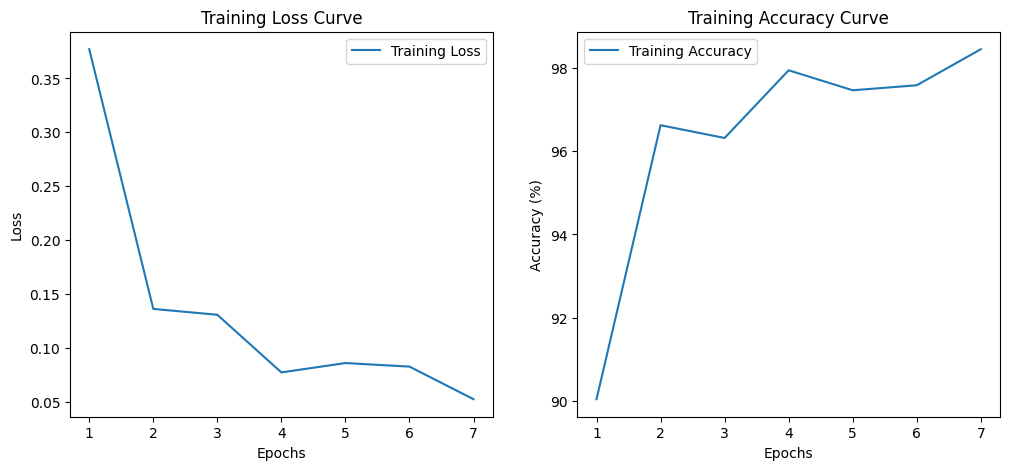

In [6]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()

plt.show()

#  Plot Confusion Matrix

This section evaluates the trained MAML model on the test set and generates a confusion matrix using Seaborn's heatmap visualization. The confusion matrix provides a summary of the model's classification performance, showing the count of true positive, false positive, true negative, and false negative predictions for each class. Each cell in the matrix represents the number of instances where a true label (row) was predicted as a specific class (column). The heatmap's color intensity indicates the frequency of predictions, with darker shades indicating higher counts. This visualization helps assess the model's accuracy and identify any misclassifications across different classes.

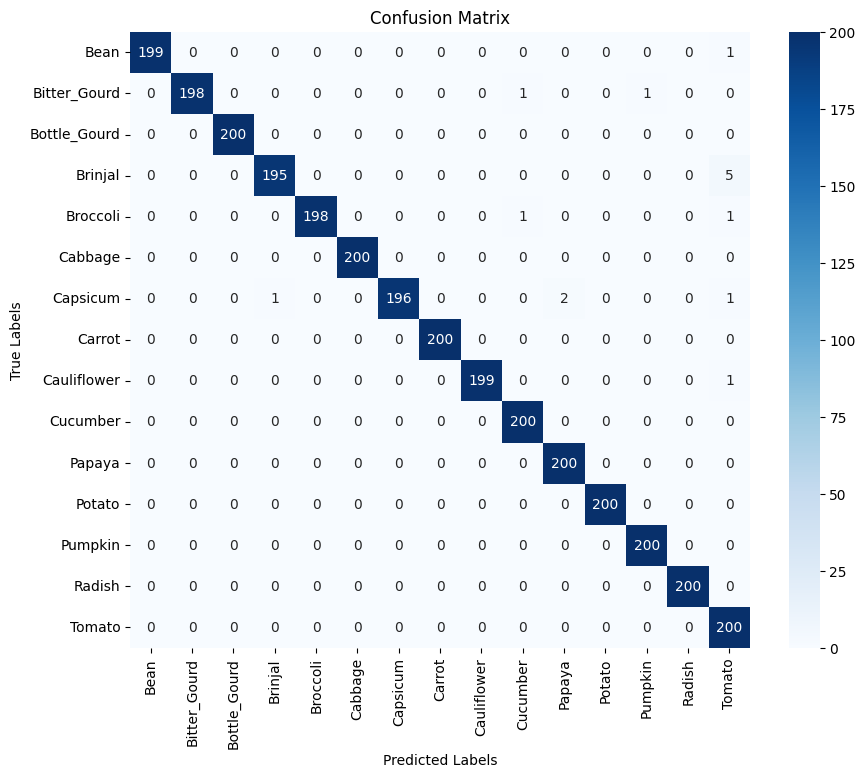

In [7]:

# **Plot confusion matrix**


# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return preds, labels

# Evaluate the MAML model
preds, labels = evaluate_model(model, test_loader)

# Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



# Calculate Evaluation Metrics

This section evaluates the MAML model's performance on the test set by computing key classification metrics using `sklearn.metrics`. It includes:
- **Accuracy:** Measures the overall correctness of predictions.
- **Precision:** Indicates the proportion of true positive predictions among all positive predictions.
- **Recall:** Measures the proportion of true positive predictions among all actual positives.
- **F1 Score:** Harmonic mean of precision and recall, providing a balanced measure between the two metrics.

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model_metrics(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return preds, labels

# Evaluate the MAML model
preds, labels = evaluate_model_metrics(model, test_loader)

# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9950
Precision: 0.9951
Recall: 0.9950
F1 Score: 0.9950


# Plot Images Function

This function visualizes a set of images from a given dataloader, showcasing both correctly classified and misclassified images by the MAML model.

### Steps:
1. **Model Evaluation:** Sets the model to evaluation mode (`model.eval()`) and initializes lists to store correctly and misclassified images and their corresponding labels.

2. **Iterate Over Data:** Loop through batches of data from the `dataloader`, moving inputs and labels to the appropriate device (`device`). Predictions are made using the model (`outputs = model(inputs)`), and predictions are compared with true labels (`predicted = torch.max(outputs, 1)`).

3. **Store Images:** Images are stored based on their classification accuracy:
   - **Correctly Classified Images:** Images where the predicted label matches the true label (`predicted[i] == labels[i]`).
   - **Misclassified Images:** Images where the predicted label does not match the true label (`predicted[i] != labels[i]`). Both the predicted and true labels are recorded for misclassified images.

4. **Plotting:**
   - **Correctly Classified Images:** Displays a subplot of correctly classified images with their predicted labels.
   - **Misclassified Images:** Displays a subplot of misclassified images, showing both true and predicted labels.

### Interpretation:
- The function provides a visual assessment of the model's performance by displaying sample images that were correctly identified and those that were misclassified. This helps in understanding where the model excels and where it may need improvement in classification tasks.

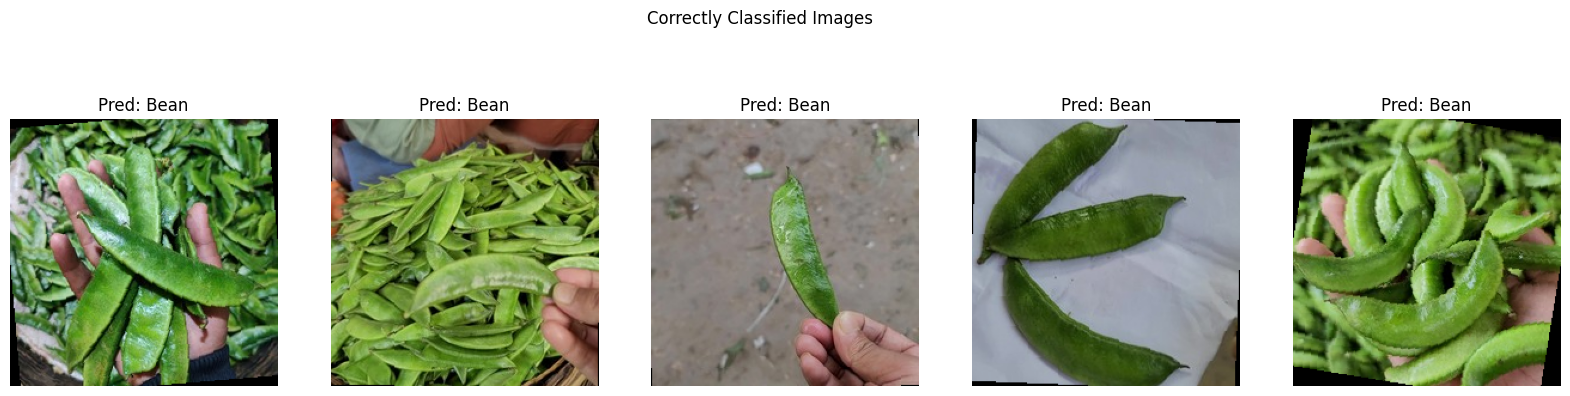

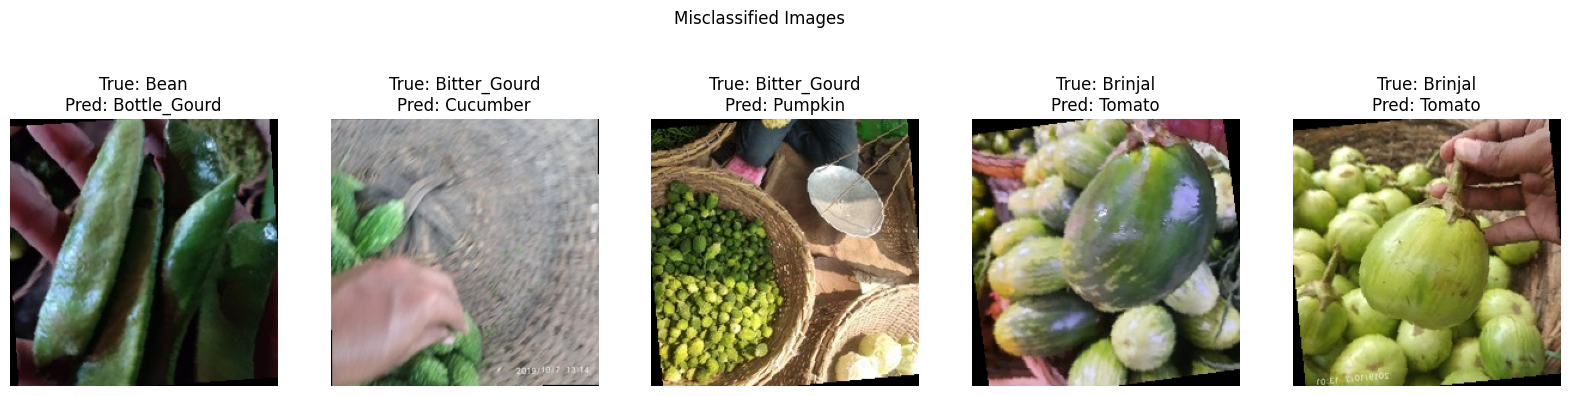

In [9]:
def plot_images(model, dataloader, num_images=5):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    correct_labels_misclassified = []
    
    correctly_classified_images = []
    correctly_classified_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if len(correctly_classified_images) < num_images and predicted[i] == labels[i]:
                    correctly_classified_images.append(inputs[i].cpu())
                    correctly_classified_labels.append(predicted[i].cpu())
                if len(misclassified_images) < num_images and predicted[i] != labels[i]:
                    misclassified_images.append(inputs[i].cpu())
                    misclassified_labels.append(predicted[i].cpu())
                    correct_labels_misclassified.append(labels[i].cpu())

    # Plot correctly classified images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        image = correctly_classified_images[i].permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        axes[i].imshow(image)
        axes[i].set_title(f'Pred: {train_dataset.classes[correctly_classified_labels[i]]}')
        axes[i].axis('off')
    plt.suptitle("Correctly Classified Images")
    plt.show()
    
    # Plot misclassified images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        image = misclassified_images[i].permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        axes[i].imshow(image)
        axes[i].set_title(f'True: {train_dataset.classes[correct_labels_misclassified[i]]}\nPred: {train_dataset.classes[misclassified_labels[i]]}')
        axes[i].axis('off')
    plt.suptitle("Misclassified Images")
    plt.show()

plot_images(model, test_loader)
